In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..')))

In [2]:
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr 
import model_setup

In [3]:
setup = model_setup.ModelSetup()

✅ Openrouter API Key exists and begins with: sk-or-v1
✅ Google API Key exists and begins with: AIzaSyDO
✅ Imagegen API Key exists and begins with: 01efb10b


In [31]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."
#system_message += "Only talk about Flights and the relevant Information for the Airline, antything else should be skipped in a formal manner."

client = OpenAI(
    api_key=setup.openrouter_api_key, 
    base_url=setup.OPENROUTER_URL
)

In [6]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = client.chat.completions.create(model=setup.DEEPSEEK_MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Tools - LLM's uses external functions to extend it's useablity  

In [24]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [25]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [26]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

In [27]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [40]:
# tools included as (tools=tools)
# response = client.chat.completions.create(model=setup.OPENAI_MODEL, messages=messages, tools=tools)


def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = client.chat.completions.create(model=setup.OPENAI_MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, _ = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = client.chat.completions.create(model=setup.OPENAI_MODEL, messages=messages)
    
    return response.choices[0].message.content

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

## Agents - Chatbot + Imagegenerator 

In [ ]:
from PIL import Image
from io import BytesIO
import base64
import requests

In [6]:
contents = ('Hi, can you create a 3d rendered image of a pig '
            'with wings and a top hat flying over a happy '
            'futuristic scifi city with lots of greenery?')

In [19]:
url = "https://ir-api.myqa.cc/v1/openai/images/generations"
payload = {
  "prompt": contents,
  "model": "google/gemini-2.0-flash-exp:free",
  "quality": "auto"
}
headers = {
  "Authorization": f"Bearer {setup.imagegen_api_key}",
  "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

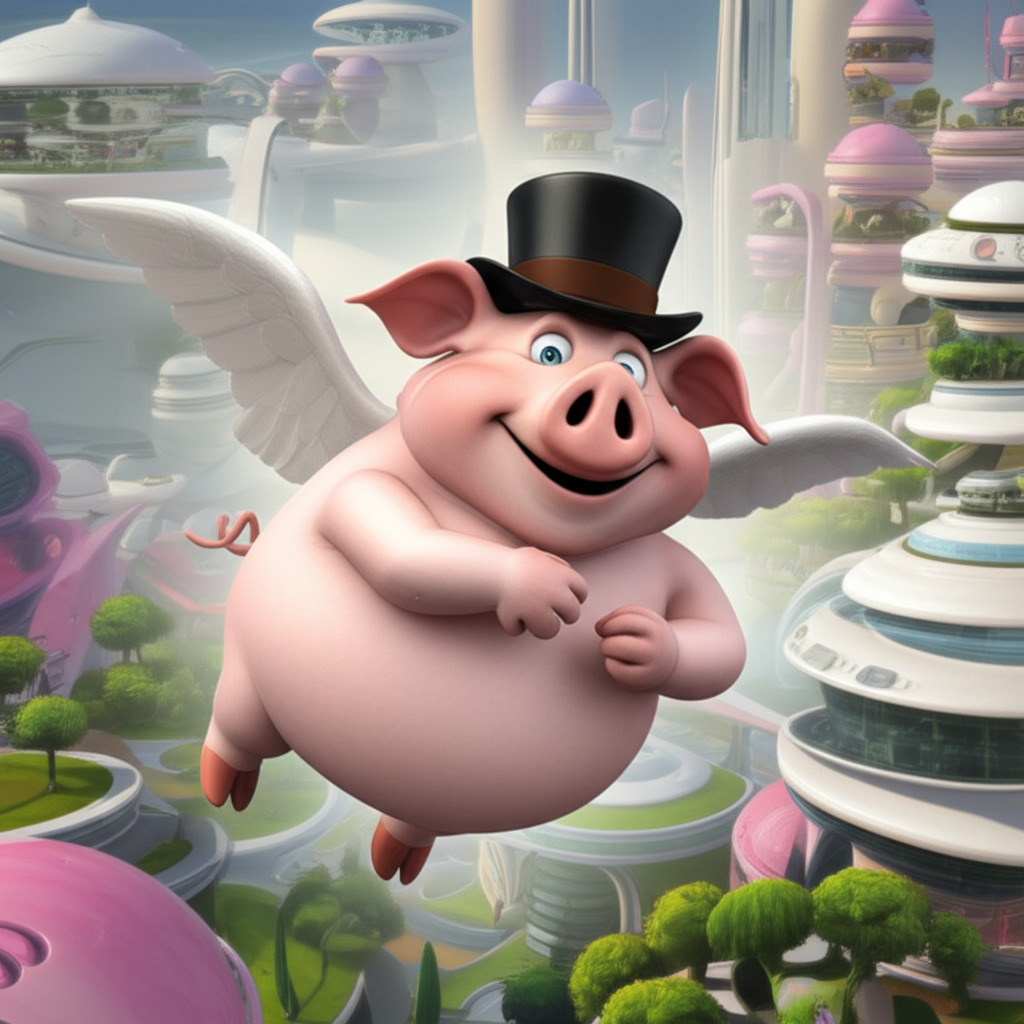

In [ ]:
response_json = response.json()

image_base64 = response_json['data'][0]['b64_json']
image_data = base64.b64decode(image_base64)
Image.open(BytesIO(image_data))

In [ ]:
def generate_image(prompt):
    url = "https://ir-api.myqa.cc/v1/openai/images/generations"
    payload = {
        "prompt": prompt,
        "model": "google/gemini-2.0-flash-exp:free",
        "quality": "auto"
    }
    headers = {
        "Authorization": f"Bearer {setup.imagegen_api_key}",
        "Content-Type": "application/json"
    }

    response = requests.post(url, json=payload, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Fehler bei der Anfrage: {response.status_code} – {response.text}")

    response_json = response.json()
    image_base64 = response_json['data'][0]['b64_json']
    image_data = base64.b64decode(image_base64)

    return Image.open(BytesIO(image_data))

In [33]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = client.chat.completions.create(model=setup.OPENAI_MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = generate_image(city)
        response = client.chat.completions.create(model=setup.OPENAI_MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    
    return history, image

In [34]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
